In [317]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

In [318]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### MIHIR MESSING AROUND WITH CURR DATA

In [319]:
### THIS WAS ME MESSING AROUND WITH CLEANING, USE TO PRACTICE PLOTTING VOLUME ###


# start_date = dt.datetime.today() - dt.timedelta(days=59)
# curr_data = yf.download("SPY", period="1y", interval="5m", start=start_date)

# SPY_curr = curr_data.rename(columns={"Close": "close", "Volume": "volume", "Open": "open", "High": "high", "Low": "low"})
# SPY_curr.columns = SPY_curr.columns.droplevel("Ticker")
# # # clean data into required format
# SPY_curr_vol = SPY_curr[["volume"]]
# SPY_curr_vol.index.name = "date"
# SPY_curr_vol.columns.name = None
# SPY_curr_vol.index = pd.to_datetime(SPY_curr_vol.index )
# SPY_curr_vol.index = SPY_curr_vol.index.tz_localize(None)
# # SPY_curr_vol

# SPY_curr_vol.plot(title="Volume");plt.show()

In [320]:
ticker = "SPY"

We import our intraday 1 minute data of SPY that ranges from ***2007-04-24*** to ***2020-01-31***.

In [321]:
# Import & clean intraday data
df = pd.read_csv("SPY1min_clean.csv", parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df['other_date'] = df[['date']]
df = df.set_index('date')
df


,open,high,low,close,volume,barCount,average,other_date
date,,,,,,,,
2008-01-22 07:30:00,126.45,126.82,126.00,126.67,30987,4541,126.283,2008-01-22 07:30:00
2008-01-22 07:31:00,126.67,127.17,126.39,127.12,20111,3125,126.958,2008-01-22 07:31:00
2008-01-22 07:32:00,127.10,127.13,126.71,126.78,11979,2074,126.922,2008-01-22 07:32:00
2008-01-22 07:33:00,126.76,126.90,126.53,126.54,8017,1350,126.675,2008-01-22 07:33:00
2008-01-22 07:34:00,126.54,127.18,126.54,126.78,11967,1253,126.730,2008-01-22 07:34:00
...,...,...,...,...,...,...,...,...
2021-05-06 13:55:00,418.56,418.77,418.48,418.49,9073,4584,418.660,2021-05-06 13:55:00
2021-05-06 13:56:00,418.50,418.73,418.47,418.64,6680,3095,418.622,2021-05-06 13:56:00
2021-05-06 13:57:00,418.64,418.79,418.63,418.79,6912,2868,418.744,2021-05-06 13:57:00


We resample the 1 minute data to a 5 minute timeframe as [Andersen et al (2000)](https://ssrn.com/abstract=267791) argue this sampling interval is optimal for a liquid market.

In [322]:
# Resample 1min to 5min
sample = '5T'
alt_df = df.resample(sample).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
alt_df.dropna(inplace = True)

alt_df.tail()

,open,high,low,close,volume
date,,,,,
2021-05-06 13:35:00,417.15,417.70,417.09,417.68,9305
2021-05-06 13:40:00,417.68,417.98,417.66,417.79,12423
2021-05-06 13:45:00,417.78,418.07,417.65,418.05,14996
2021-05-06 13:50:00,418.04,418.84,418.03,418.56,43476
2021-05-06 13:55:00,418.56,419.21,418.47,419.08,48899


In [323]:
# Download VIX & SPY volume data from yahoo finance
SPY_daily = alt_df[["volume"]]
SPY_daily 

,volume
date,
2008-01-22 07:30:00,83061
2008-01-22 07:35:00,69696
2008-01-22 07:40:00,78193
2008-01-22 07:45:00,90224
2008-01-22 07:50:00,113235
...,...
2021-05-06 13:35:00,9305
2021-05-06 13:40:00,12423
2021-05-06 13:45:00,14996


Now that we have the data, there are 4 major steps to follow:
- Compute daily realized volatilty from intraday data.
- Average the values over 5 periods to get rolling weekly realized volatility and 22 periods for monthly realized volatility.
- Estimate the HAR-RV coefficients.
- Measure the performance of the model.

We start by computing the daily RV, based on $n$ intraday prices:
$RV^d_t =  \sqrt {\sum_{j=0}^{n-1} r^2_{t-j\Delta}}$

Where:
- $r_{t-j\Delta} = \Delta \left(p_{t-j} - p_{t-(j+1)}\right)$
- $\Delta = 1d/n_{periods}$
- $p_t$ is the price at time $t$
- $n$ is the number of 5 minute bars in a trading day

In [324]:
alt_df

,open,high,low,close,volume
date,,,,,
2008-01-22 07:30:00,126.45,127.18,126.00,126.78,83061
2008-01-22 07:35:00,126.80,127.89,126.12,127.65,69696
2008-01-22 07:40:00,127.58,128.26,127.00,128.10,78193
2008-01-22 07:45:00,128.08,129.30,128.03,129.03,90224
2008-01-22 07:50:00,129.02,129.86,128.92,129.25,113235
...,...,...,...,...,...
2021-05-06 13:35:00,417.15,417.70,417.09,417.68,9305
2021-05-06 13:40:00,417.68,417.98,417.66,417.79,12423
2021-05-06 13:45:00,417.78,418.07,417.65,418.05,14996


### MIHIR START FROM HERE, THIS IS WHERE THE ACTUAL WORKING CODE STARTS ###

In [325]:

### WORKING CODE THAT PULLS FROM YF AND PROCESSES IN THE WAY WE WANT ###

# pull initial data from yfinance
start_date = dt.datetime.today() - dt.timedelta(days=59)
curr_data = yf.download("SPY", period="1y", interval="5m", start=start_date)
curr_data = curr_data[curr_data['Volume'] != 0]
curr_data = curr_data.dropna()

# clean 5m interval data to process best for har-rv
curr_data_cleaned = curr_data.rename(columns={"Close": "close", "Volume": "volume", "Open": "open", "High": "high", "Low": "low"})
curr_data_cleaned.columns = curr_data_cleaned.columns.droplevel("Ticker")
curr_data_cleaned.index = curr_data_cleaned.index.tz_convert("America/New_York").tz_localize(None)
curr_data_cleaned.index.name = "date"
curr_data_cleaned.columns.name = None

curr_data_cleaned.to_csv("SPY_5m_data.csv")

[*********************100%***********************]  1 of 1 completed


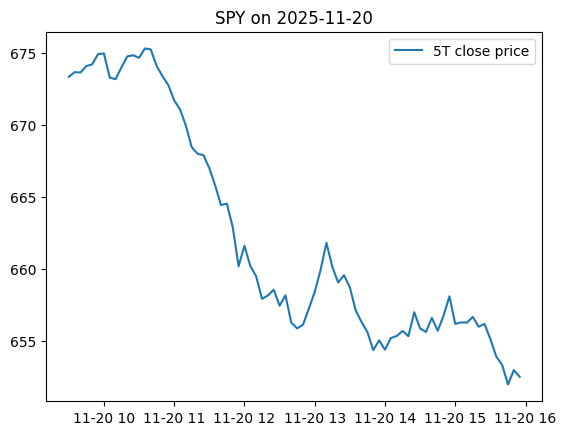

In [326]:
### WORKIGN HAR RV CALC ###

curr_df = curr_data_cleaned
curr_df["D"] = curr_df.index.date
n_periods = curr_df.pivot_table(index = ["D"], aggfunc = 'size').values
curr_df.loc[curr_df["D"] != curr_df["D"].shift(), "Per"] = n_periods
curr_df.fillna(method = 'ffill', inplace = True)
curr_df["Ret"] = np.where(curr_df["D"] == curr_df["D"].shift(), ( (curr_df["close"]-curr_df["close"].shift()) * 1/curr_df["Per"] ) **2, np.nan)
curr_rv = curr_df.groupby("D")["Ret"].agg(np.sum).to_frame()
curr_rv.columns = ["RV_daily"]
curr_rv["RV_daily"] = np.sqrt(curr_rv["RV_daily"])
date = str(curr_rv["RV_daily"].idxmax())
curr_df["close"].loc[date]
date = str(curr_rv["RV_daily"].idxmax())

## used to see highest vol day
plt.plot(curr_df["close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

In [327]:
curr_df

,close,high,low,open,volume,D,Per,Ret
date,,,,,,,,
2025-10-15 09:30:00,666.549988,667.164978,666.229980,666.820007,4244583,2025-10-15,78.0,NaN
2025-10-15 09:35:00,666.640015,667.460022,666.479980,666.549988,1679047,2025-10-15,78.0,1.332156e-06
2025-10-15 09:40:00,667.190002,667.625000,666.630005,666.640015,1450535,2025-10-15,78.0,4.971837e-05
2025-10-15 09:45:00,666.349976,667.880005,666.049988,667.200012,1832353,2025-10-15,78.0,1.159837e-04
2025-10-15 09:50:00,667.590027,667.815002,666.159973,666.348877,1642637,2025-10-15,78.0,2.527494e-04
...,...,...,...,...,...,...,...,...
2025-12-12 15:35:00,680.335022,681.130005,680.070007,681.020020,1645347,2025-12-12,78.0,7.712387e-05
2025-12-12 15:40:00,680.839722,681.140015,680.320007,680.340027,1795690,2025-12-12,78.0,4.186749e-05
2025-12-12 15:45:00,681.359985,681.869995,680.729980,680.840027,2339018,2025-12-12,78.0,4.448953e-05


In [328]:
# alt_df = curr_data_cleaned.copy()
# alt_df = alt_df[["close", "high", "low", "volume", "open"]]
# alt_df
SPY_daily = alt_df[["volume"]]
SPY_daily_current = curr_df[["volume"]]
SPY_daily


,volume
date,
2008-01-22 07:30:00,83061
2008-01-22 07:35:00,69696
2008-01-22 07:40:00,78193
2008-01-22 07:45:00,90224
2008-01-22 07:50:00,113235
...,...
2021-05-06 13:35:00,9305
2021-05-06 13:40:00,12423
2021-05-06 13:45:00,14996


In [329]:
# Compute number of periods/day
# alt_df = curr_data_cleaned
alt_df["D"] = alt_df.index.date
n_periods = alt_df.pivot_table(index = ["D"], aggfunc = 'size').values
stats.describe(n_periods)


DescribeResult(nobs=np.int64(3347), minmax=(np.int64(42), np.int64(192)), mean=np.float64(85.61667164625037), variance=np.float64(810.5347249617868), skewness=np.float64(3.3986754989604826), kurtosis=np.float64(9.887705168277847))

In [331]:
curr_df


,close,high,low,open,volume,D,Per,Ret
date,,,,,,,,
2025-10-15 09:30:00,666.549988,667.164978,666.229980,666.820007,4244583,2025-10-15,78.0,NaN
2025-10-15 09:35:00,666.640015,667.460022,666.479980,666.549988,1679047,2025-10-15,78.0,1.332156e-06
2025-10-15 09:40:00,667.190002,667.625000,666.630005,666.640015,1450535,2025-10-15,78.0,4.971837e-05
2025-10-15 09:45:00,666.349976,667.880005,666.049988,667.200012,1832353,2025-10-15,78.0,1.159837e-04
2025-10-15 09:50:00,667.590027,667.815002,666.159973,666.348877,1642637,2025-10-15,78.0,2.527494e-04
...,...,...,...,...,...,...,...,...
2025-12-12 15:35:00,680.335022,681.130005,680.070007,681.020020,1645347,2025-12-12,78.0,7.712387e-05
2025-12-12 15:40:00,680.839722,681.140015,680.320007,680.340027,1795690,2025-12-12,78.0,4.186749e-05
2025-12-12 15:45:00,681.359985,681.869995,680.729980,680.840027,2339018,2025-12-12,78.0,4.448953e-05


We then compute $r^2_{t-j\Delta}$ for all days.  

In [332]:
alt_df.loc[alt_df["D"] != alt_df["D"].shift(), "Per"]  = n_periods
alt_df.fillna(method = 'ffill', inplace = True)

alt_df["Ret"] = np.where(alt_df["D"] == alt_df["D"].shift(),
                    ( (alt_df["close"]-alt_df["close"].shift()) * 1/alt_df["Per"] ) **2, np.nan)

In [ ]:
# Perform the sum grouped by days.
rv = alt_df.groupby("D")["Ret"].agg(np.sum).to_frame()

In [334]:
# Add sqrt to get Realized-Vol
rv.columns = ["RV_daily"]
rv["RV_daily"] = np.sqrt(rv["RV_daily"])

In [338]:
rv

,RV_daily
D,
2008-01-22,0.042742
2008-01-23,0.043714
2008-01-24,0.029548
2008-01-25,0.026224
2008-01-28,0.025124
...,...
2021-04-30,0.027480
2021-05-03,0.020792
2021-05-04,0.041962


In [339]:
date = str(rv["RV_daily"].idxmax())
df["close"].loc[date]

date
2020-03-12 07:30:00    256.32
2020-03-12 07:31:00    256.40
2020-03-12 07:32:00    256.08
2020-03-12 07:33:00    255.66
2020-03-12 07:34:00    255.29
                        ...  
2020-03-12 13:55:00    251.41
2020-03-12 13:56:00    250.11
2020-03-12 13:57:00    250.18
2020-03-12 13:58:00    249.01
2020-03-12 13:59:00    248.08
Name: close, Length: 390, dtype: float64

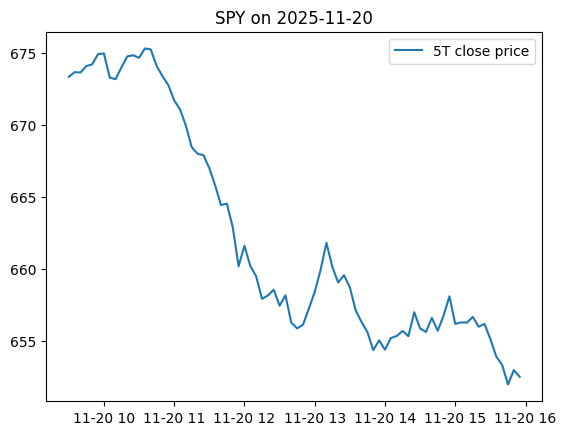

In [ ]:
# Check what day in the dataset had the highest realized vol
date = str(rv["RV_daily"].idxmax())
plt.plot(df["close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

We can compute the weekly and monthly RV with:
- Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
- Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

In [343]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

curr_rv["RV_weekly"] = curr_rv["RV_daily"].rolling(5).mean()
curr_rv["RV_monthly"] = curr_rv["RV_daily"].rolling(21).mean()
curr_rv.dropna(inplace = True)

In [345]:
curr_rv

,RV_daily,RV_weekly,RV_monthly
D,,,
2025-11-12,0.040182,0.051210,0.050120
2025-11-13,0.068698,0.051228,0.050249
2025-11-14,0.079866,0.053195,0.050078
2025-11-17,0.072962,0.059438,0.049901
2025-11-18,0.089837,0.070309,0.052734
2025-11-19,0.079111,0.078095,0.054757
2025-11-20,0.113978,0.087151,0.057118
2025-11-21,0.102117,0.091601,0.060063
2025-11-24,0.050077,0.087024,0.061206


In [347]:
SPY_daily = alt_df[["volume"]]
SPY_daily.index

SPY_daily_curr = curr_df[["volume"]]
SPY_daily_curr.index

DatetimeIndex(['2025-10-15 09:30:00', '2025-10-15 09:35:00',
               '2025-10-15 09:40:00', '2025-10-15 09:45:00',
               '2025-10-15 09:50:00', '2025-10-15 09:55:00',
               '2025-10-15 10:00:00', '2025-10-15 10:05:00',
               '2025-10-15 10:10:00', '2025-10-15 10:15:00',
               ...
               '2025-12-12 15:10:00', '2025-12-12 15:15:00',
               '2025-12-12 15:20:00', '2025-12-12 15:25:00',
               '2025-12-12 15:30:00', '2025-12-12 15:35:00',
               '2025-12-12 15:40:00', '2025-12-12 15:45:00',
               '2025-12-12 15:50:00', '2025-12-12 15:55:00'],
              dtype='datetime64[ns]', name='date', length=3238, freq=None)

In [348]:
SPY_daily = SPY_daily.resample('D')['volume'].sum().reset_index()
SPY_daily_curr = SPY_daily_curr.resample('D')['volume'].sum().reset_index()

In [ ]:
SPY_daily = SPY_daily.set_index("date")
SPY_daily_curr = SPY_daily_curr.set_index("date")

KeyError: "None of ['date'] are in the columns"

In [351]:
SPY_daily_curr

,volume
date,
2025-10-15,75676554
2025-10-16,100488904
2025-10-17,84852579
2025-10-18,0
2025-10-19,0
2025-10-20,52893074
2025-10-21,50784839
2025-10-22,74191348
2025-10-23,57429074


In [353]:
curr_rv

,RV_daily,RV_weekly,RV_monthly
D,,,
2025-11-12,0.040182,0.051210,0.050120
2025-11-13,0.068698,0.051228,0.050249
2025-11-14,0.079866,0.053195,0.050078
2025-11-17,0.072962,0.059438,0.049901
2025-11-18,0.089837,0.070309,0.052734
2025-11-19,0.079111,0.078095,0.054757
2025-11-20,0.113978,0.087151,0.057118
2025-11-21,0.102117,0.091601,0.060063
2025-11-24,0.050077,0.087024,0.061206


In [356]:
#Add IV & Volume variables
rv["SPY_volume"] = SPY_daily.loc[rv.index]
curr_rv["SPY_volume"] = SPY_daily_curr.loc[curr_rv.index]

print(rv.head()); print(rv.describe())
# print(curr_rv.head()); print(curr_rv.describe())

            RV_daily  RV_weekly  RV_monthly  SPY_volume
D                                                      
2008-03-19  0.024540   0.028822    0.021764     2949495
2008-03-20  0.020874   0.027321    0.021815     8713228
2008-03-24  0.016011   0.023274    0.021742     1866323
2008-03-25  0.015973   0.020661    0.021505     1633184
2008-03-26  0.016754   0.018831    0.021130     1708104
          RV_daily    RV_weekly   RV_monthly    SPY_volume
count  3307.000000  3307.000000  3307.000000  3.307000e+03
mean      0.016317     0.016315     0.016304  1.654588e+06
std       0.013206     0.012027     0.010469  1.766783e+06
min       0.003274     0.003959     0.006113  1.853590e+05
25%       0.009636     0.010165     0.010527  6.165390e+05
50%       0.013045     0.013237     0.013310  1.097894e+06
75%       0.018260     0.018028     0.019004  1.959470e+06
max       0.202157     0.166490     0.118118  2.315890e+07


In [357]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])
print("p-value for SPY Volume:",adf(rv["SPY_volume"].values)[1])

print("p-value for daily RV:", adf(curr_rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(curr_rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(curr_rv["RV_monthly"].values)[1])
print("p-value for SPY Volume:",adf(curr_rv["SPY_volume"].values)[1])

p-value for daily RV: 1.4637786256926414e-09
p-value for weekly RV: 8.146867426609018e-08
p-value for monthly RV: 1.3087169351767037e-08
p-value for SPY Volume: 0.010817249793096718
p-value for daily RV: 3.799794068354149e-05
p-value for weekly RV: 0.265893515289516
p-value for monthly RV: 0.0
p-value for SPY Volume: 0.8998088540200748


For all timeframes, the p-value is $\le 0.01$ thus, we reject the null hypothesis that the time series has a unit root.  The time series is stationary.

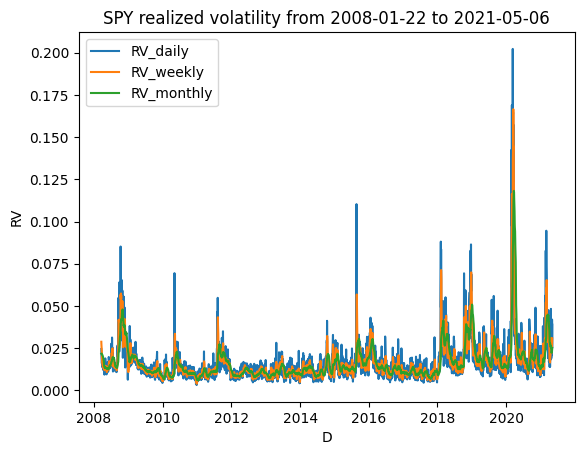

In [358]:
# Plot the RV variables.  
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"{ticker} realized volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()

As the volume, RVs and VIX price have significantly different ranges, we perform min-max normalization:

$X_{scaled} = \frac{X - min(X)}{max(X)-min(X)}$

In [359]:
# Prepare data 
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
curr_rv["Target"] = curr_rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  

rv.dropna(inplace = True)
curr_rv.dropna(inplace = True)

#Scale the data
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())
curr_rv_scaled = (curr_rv-curr_rv.min())/(curr_rv.max()-curr_rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)
curr_rv_scaled = sm.add_constant(curr_rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
X_curr = curr_rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
y_curr = curr_rv_scaled[["Target"]]
X_train, X_test = X[:split], X_curr
y_train, y_test = y[:split], y_curr

In [362]:
X_test

,const,RV_daily,RV_weekly,RV_monthly,SPY_volume
D,,,,,
2025-11-12,1.0,0.160074,0.266587,0.014437,0.197534
2025-11-13,1.0,0.484635,0.266924,0.022979,0.471083
2025-11-14,1.0,0.611743,0.302640,0.011715,0.489096
2025-11-17,1.0,0.533169,0.415998,0.000000,0.411862
2025-11-18,1.0,0.725232,0.613390,0.186605,0.626620
2025-11-19,1.0,0.603145,0.754759,0.319859,0.432636
2025-11-20,1.0,1.000000,0.919194,0.475355,1.000000
2025-11-21,1.0,0.865000,1.000000,0.669325,0.678961
2025-11-24,1.0,0.272696,0.916892,0.744630,0.278977


We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

We do this with OLS:
$\hat{\beta} = (X'X)^{-1}X'Y$

In [363]:
results = sm.OLS(y_train, X_train).fit()
from sklearn.linear_model import Ridge

# ridge_model = Ridge(alpha=2)
# ridge_model.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=10000, random_state=42)
# rf_model.fit(X_train, y_train)

# from sklearn.linear_model import LogisticRegression

# lr_model = LogisticRegression(random_state=42, solver='liblinear') # Using liblinear solver for small datasets or L1/L2 regularization
# lr_model.fit(X_train, y_train)

# from sklearn.ensemble import GradientBoostingRegressor

# gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# gb_model.fit(X_train, y_train)

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     858.7
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:39:32   Log-Likelihood:                 4547.4
No. Observations:                1983   AIC:                            -9085.
Df Residuals:                    1978   BIC:                            -9057.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.001      8.332      0.000       0.006       0.010
RV_daily       0.4770      0.027     17.776      0.000       0.424       0.530
RV_weekly      0.2459      0.032      7.627      0.000       0.183       0.309
RV_monthly     0.0961      0.019      5.040      0.000       0.059       0.134
SPY_volume    -0.0222      0.007     -3.093      0.002      -0.036      -0.008
==============================================================================
Omnibus:                     2080.325   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           372388.903
Skew:                           4.725   Prob(JB):                         0.00
Kurtosis:                      69.466   Cond. No.                         72.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $\hat{\beta_3}$ (***RV_monthly***) and $\hat{\beta_5}$ (***SPY_volume***), we do not reject the null hypothesis.  Thus, these variables are not statistically significant when making a next day forecast.

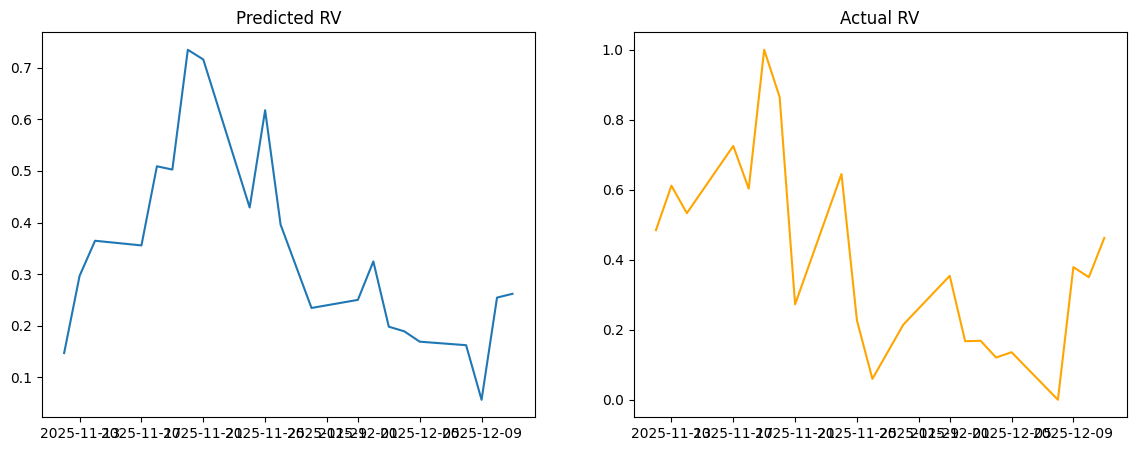

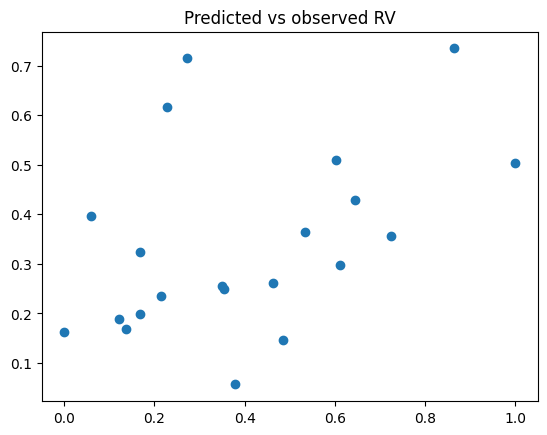

In [364]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [365]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [366]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0005965719921684363, R^2:0.6345621718465364, MAE:0.014493877567748151
----------------
Out-of-sample scores
MSE:0.06583861630888901, R^2:0.061865172057895434, MAE:0.21390688348704218


The explanatory variables explain $59.6\%$ of the variance of the dependent variable out-of-sample.

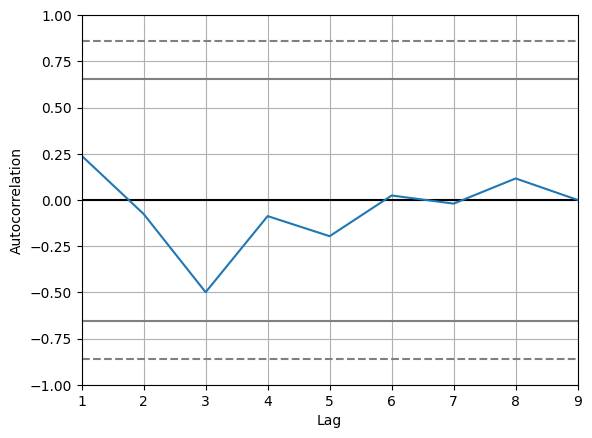

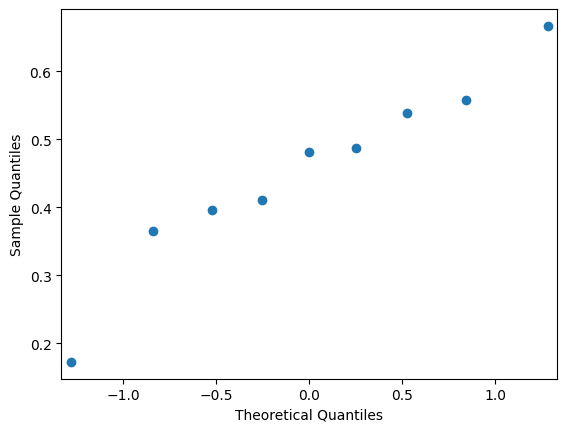

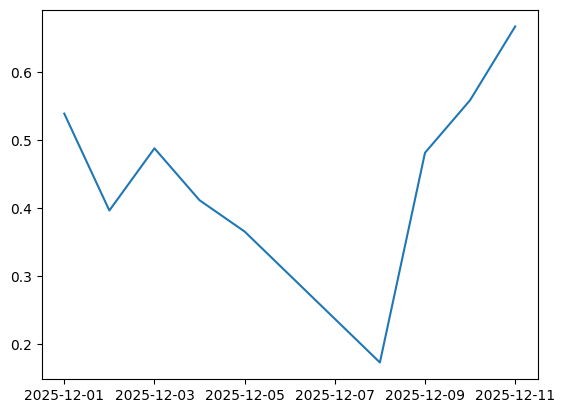

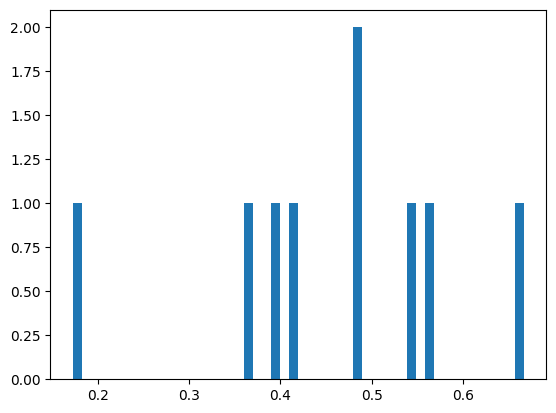

In [261]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()

The residuals appear to look like white noise.